## Baseline

In this Notebook the baseline will be established. All other models will be compared to this results.
We will use SGDClassifier without any optimization.

### At the end of this notebook 

you will find a summary of the F1-Score comparision of different models vs this baseline.

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.3'
!pip install pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 22.2 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 366 kB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 4.5 MB/s eta 0:00:011
     |████████████████████████████████| 306 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 748 kB 6.1 MB/s et

  Created wheel for thrift: filename=thrift-0.15.0-cp36-cp36m-linux_x86_64.whl size=345146 sha256=32af8027086d20e94cea6bed735c3bafc18a764773cac1e2d18523b75024a693
  Stored in directory: /root/.cache/pip/wheels/2a/91/a0/aea72c790bd97f9c2f31ac5ca0b20b25992010a31e4357f50b
Successfully built thrift
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Create in Data cleaning
file = "data/german_news_articles_original_train_and_test_tokenized.parq"
data_all = load_dataframe(file)

In [3]:
data_all.sample(3)

,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
1526,Finanzminister Hans Jörg Schelling steht vor s...,Inland,train,Finanzminister Hans Jörg Schelling steht vor s...,"[finanzminister, hans, jörg, schelling, steht,...","[finanzminister, hans, jörg, schelling, stehen...","[finanzminist, han, jorg, schelling, steht, er...","[finanzminister, hans, jörg, schelling, steht,..."
8152,Männchen der neuen Gattung von Riesenkrabbensp...,Wissenschaft,train,Männchen der neuen Gattung von Riesenkrabbensp...,"[männchen, neuen, gattung, riesenkrabbenspinne...","[männchen, neu, gattung, riesenkrabbenspinnen,...","[mannch, neu, gattung, riesenkrabbenspinn, bei...","[männchen, neuen, gattung, riesenkrabbenspinne..."
5016,Partei könnte politischen Konflikt im Land wei...,International,train,Partei könnte politischen Konflikt im Land wei...,"[partei, politischen, konflikt, land, verschär...","[partei, politisch, konflikt, land, verschärfe...","[partei, polit, konflikt, land, verscharf, bei...","[partei, politischen, konflikt, land, verschär..."


Once more have a look at the dataset. It is rather small with only 10K entries.
Also some categories are much more popular than other (web and panorama).

Implement the original split train/test again which was proposed by the authors of the dataset by using the column split.
Also split the train set further into train and validation.

In [4]:
from sklearn.model_selection import train_test_split

data_train_orig = data_all.loc[(data_all["split"] == "train")]
data_test_orig = data_all.loc[(data_all["split"] == "test")]

X_train, y_train = data_train_orig["token_lemma"], data_train_orig["label"]
X_test, y_test = data_test_orig["token_lemma"], data_test_orig["label"]

In [5]:
%%time
# Basic Baseline model
# Noting to do in CountVectorizer as we already did tokenize and used stopwords -> use identity lambda
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])
pipe.fit(X_train, y_train)

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.45 s


Pipeline(steps=[('vec',
                 CountVectorizer(preprocessor=<function <lambda> at 0x7f756a9fbae8>,
                                 tokenizer=<function <lambda> at 0x7f756c63c840>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [6]:
# Predict on test set for baseline evaluation
y_test_pred = pipe.predict(X_test)

In [7]:
import class_result
import os
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, output_dict=False))

               precision    recall  f1-score   support

         Etat       0.90      0.82      0.86        67
       Inland       0.85      0.84      0.85       102
International       0.88      0.81      0.85       151
       Kultur       0.84      0.87      0.85        54
     Panorama       0.81      0.84      0.82       168
        Sport       0.99      0.99      0.99       120
          Web       0.92      0.91      0.92       168
   Wirtschaft       0.83      0.87      0.85       141
 Wissenschaft       0.90      0.96      0.93        57

     accuracy                           0.88      1028
    macro avg       0.88      0.88      0.88      1028
 weighted avg       0.88      0.88      0.88      1028



Actually the results are quiet good. The larger the class the better the result (to be expected).


Set Population: 1028
Accuracy: 0.8774


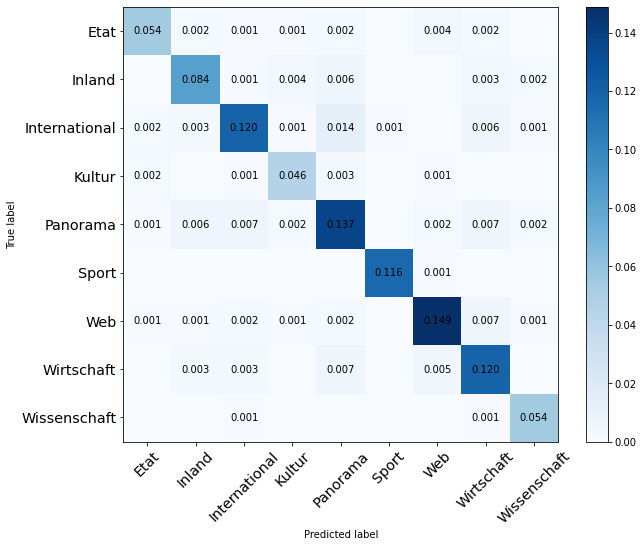

In [8]:
from fhnw.nlp.utils.ploting import plot_confusion_matrix

plot_confusion_matrix(y_test, y_test_pred)

## Baseline Result vs other classifiers

Here you find a table which compares different F1-Scores calculated with CountVectorizer and TfidfTransformer using
different Classifiers, Params and Lemmatization and Stemming.

The **winner is SGDClassifier on Stemmed tokens after optimization with BayesSearchCV**. But the different to the baseline above is just marginal

- As as Classifier SGDClassifier seems to be the winner. It is surprising how good the above baseline without any tweaking or optimization is performing. 
- Stemming seems to deliver slightly improved results than Lemmatization
- 2 Gram always seems to be worse than 1 Gram


The calculation of the other models can be found in 
[PA_Classification_Expermiments](03_PA_Classification_Expermiments.ipynb)

Here the description of the different columns
- f1- baseline: SGD Classifier 1 Gram on token_lemma (see this notebook)
- f1-one vs one: OneVsOneClassifier  Gram on token_lemma
- f1-baseline 2 Gram: SGD Classifier 1 and 2 Gram on token_lemma
- f1-kNN: K-Nearest Neighbours Classifier 1 Gram on token_lemma
- f1-Random Forest: Random Forest Classifier  1 Gram on token_lemma
- f1-Naiv Bayes: Naive Bayes Classifier  1 Gram on token_lemma
- f1-baseline stemming: SGD Classifier 1 Gram on on token_stem (Stemming tokens)
- **f1-baseline stemming optimized**: SGD Classifier 1 Gram on on token_stem (Stemming tokens) using BayesSearchCV
- f1-dummy-clf: Dummy classifier stratified

The following table shows the F1 Score of the different models.


![classification_results.png.png](classification_results.png)


I also used the data to train on **Google Vertex AI (Auto ML)**. 

See steps in [PA_AutoML Data Prep](04_PA_AutoML%20Data%20Prep.ipynb)

Had some difficulties to compare the result with the result above. 
But it seems that Auto ML is doing worse than the baseline. I assume that the average 

F1-Score at confidence 50% is 0.8754308

In [23]:
# This is how the above image was created
import os
import class_result

filename = 'data/overview_classification_results.csv'
df_classification_results = pd.read_csv(filename, index_col=0)
print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightblue', axis = 1)

All F1 Score - Maximum highlighted


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-baseline stemming,f1-baseline stemming optimized,f1-dummy clf
Etat,0.850394,0.848000,0.806723,0.753846,0.568421,0.029412,0.852713,0.859375,0.031746
Inland,0.835821,0.827586,0.831683,0.770563,0.780488,0.717647,0.848485,0.869565,0.040201
International,0.855172,0.849123,0.823529,0.813115,0.788274,0.830450,0.851351,0.851351,0.190184
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.859813,0.878505,0.055556
Panorama,0.829412,0.802228,0.804598,0.738028,0.717087,0.631791,0.838150,0.826347,0.197015
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.987448,0.991667,0.150794
Web,0.908012,0.900901,0.908012,0.835913,0.850000,0.756219,0.925373,0.923077,0.127796
Wirtschaft,0.849315,0.813559,0.823129,0.747253,0.719723,0.785965,0.851211,0.844291,0.141343
Wissenschaft,0.924370,0.902655,0.905983,0.796117,0.844037,0.000000,0.905983,0.905983,0.052632
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.880350,0.881323,0.131323
